# KURS ZŁOTEGO

In [1]:
import pandas as pd
from alpha_vantage.foreignexchange import ForeignExchange
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import datetime
from time import sleep
from os import environ
import pytz

/tmp/ipykernel_1806/604843737.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
tz = pytz.timezone('Europe/Warsaw')
print(f'Ostatnia aktualizacja: {datetime.now(tz=tz)}')

Ostatnia aktualizacja: 2024-02-21 10:03:36.665308+01:00


In [3]:
AV_API_KEY = environ['AV_API_KEY']
cc = ForeignExchange(key=AV_API_KEY, output_format='pandas')

currencies = ['EURPLN', 'USDPLN', 'CHFPLN', 'GBPPLN']

class Currency:
    def __init__(self, currency: str, data):
        self.currency = currency
        self.data = data
    
    @classmethod
    def load_currency(cls, currency):
        while True:
            try:
                df, _ = cc.get_currency_exchange_daily(currency[:3], currency[3:])
                df = df.sort_index(ascending=True)
                df.columns = ["open", "high", "low", "close"]
                return cls(currency, df)
            except ValueError:
                delay = 15
                print(f'Waiting {delay} seconds before the next API call for {currency}...')
                sleep(15)
                continue
            break


currencies_data = {}

for currency in currencies:
    currencies_data[currency] = Currency.load_currency(currency)
print('SUCCESS')

SUCCESS


In [4]:
print(f'Ostatni kurs z dnia {max(currencies_data["EURPLN"].data.index).strftime("%Y-%m-%d")}')
for currency in currencies_data:
    print(f'{currency}: {currencies_data[currency].data.loc[max(currencies_data[currency].data.index), "close"]}')

Ostatni kurs z dnia 2024-02-21
EURPLN: 4.31707
USDPLN: 4.00062
CHFPLN: 4.5393
GBPPLN: 5.04139


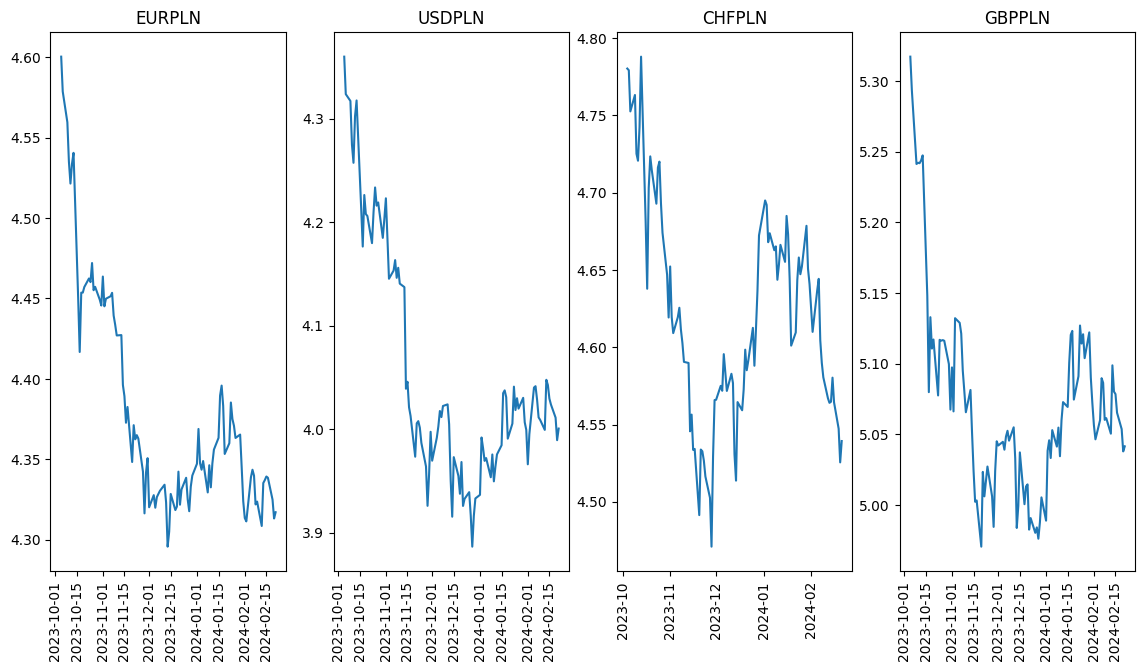

In [5]:
plt.figure(figsize=(14, 7))
plt.tight_layout()

for idx, currency_data in enumerate(currencies_data.items(), 1):
    currency, data = currency_data
    plt.subplot(1, len(currencies_data), idx)
    plt.xticks(rotation=90)
    plt.title(currency)
    plt.plot(data.data["close"])

plt.show()

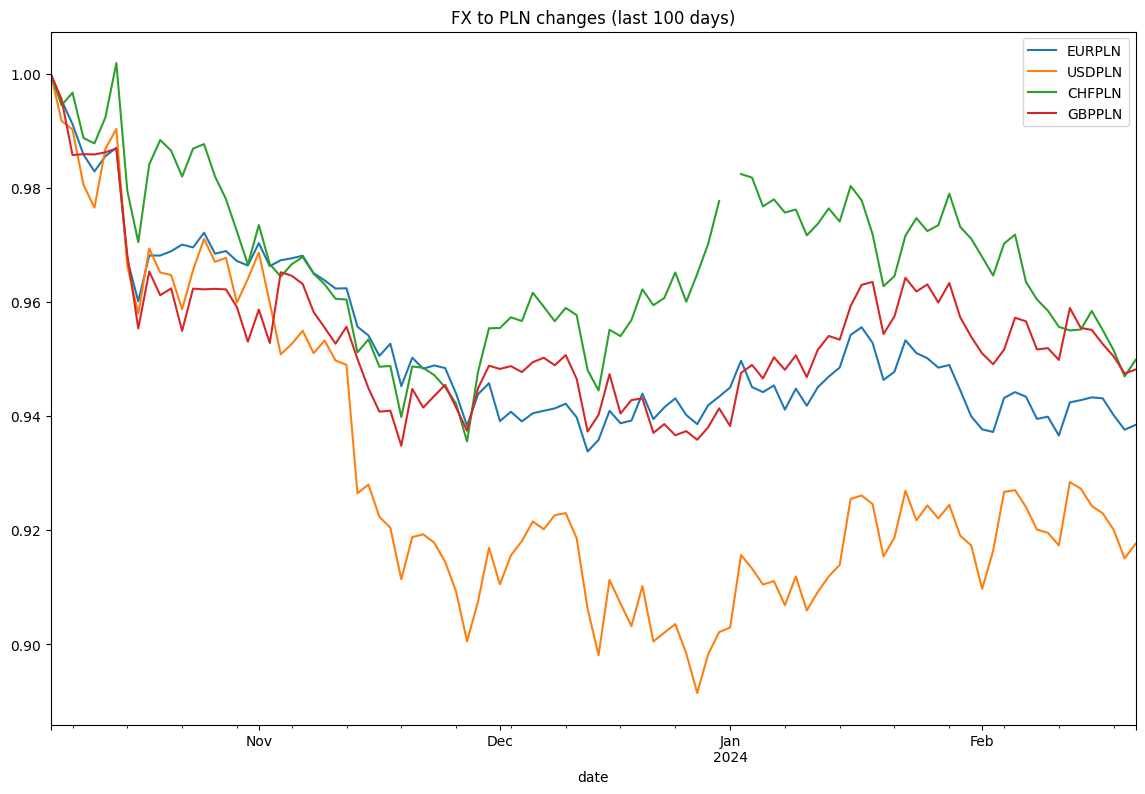

In [6]:
fx_based = pd.DataFrame(columns = currencies)

for idx, currency_data in enumerate(currencies_data.items(), 1):
    currency, data = currency_data
    fx_based[currency] = data.data["close"]
fx_based = fx_based.div(fx_based.iloc[0])

fx_based.plot(title='FX to PLN changes (last 100 days)', figsize = (14,9))
plt.show()

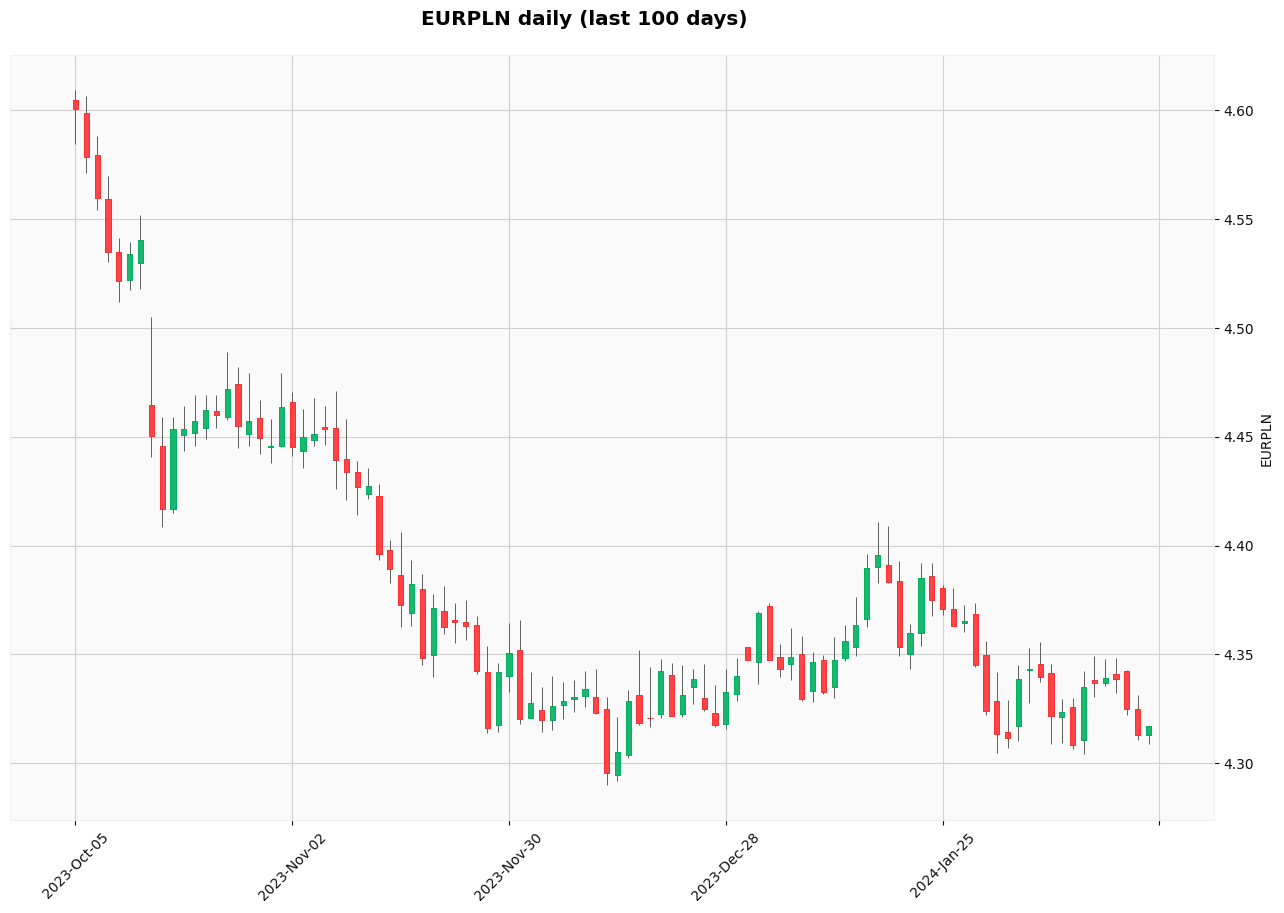

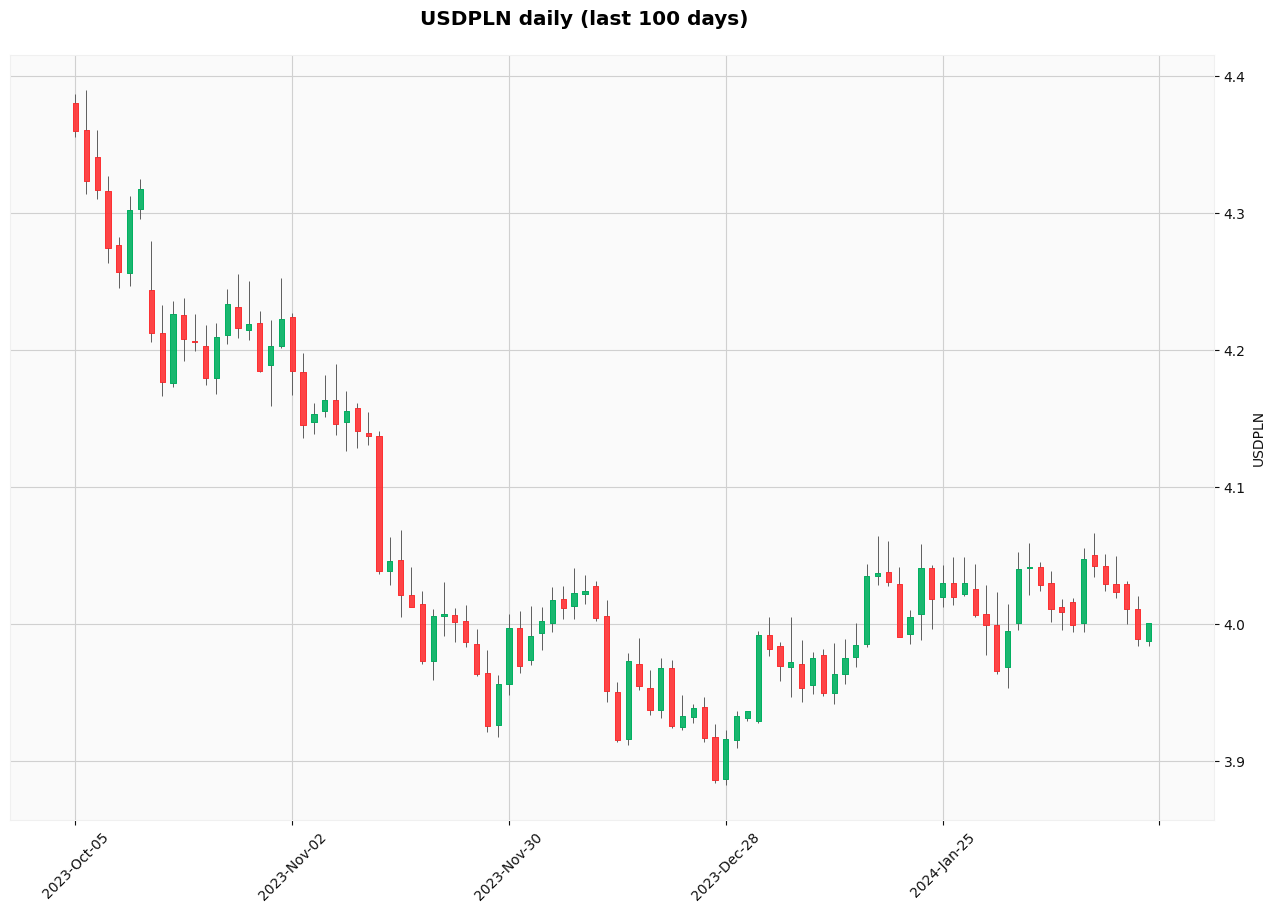

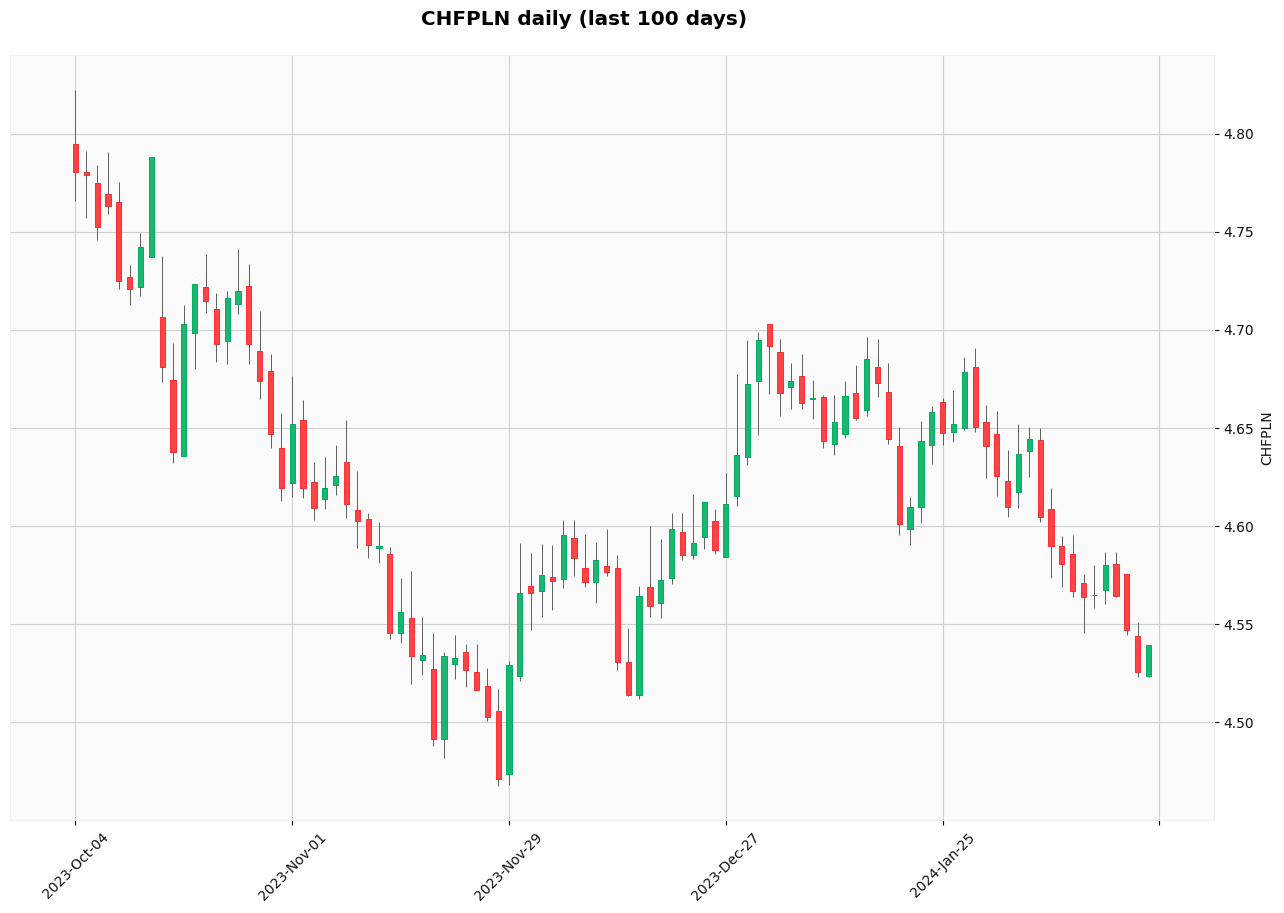

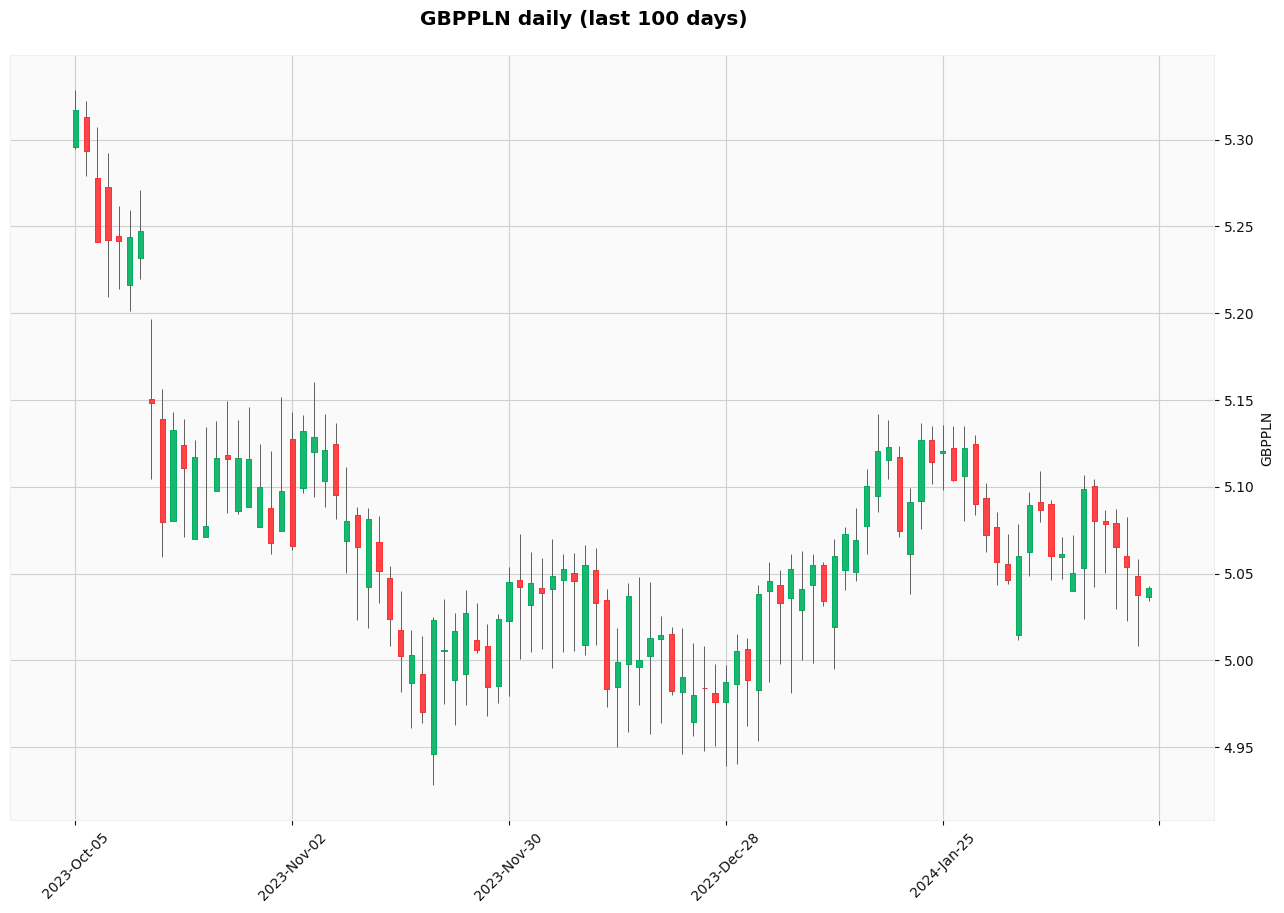

In [7]:
for currency_data in currencies_data.items():
    currency, data = currency_data
    
    combined = pd.DataFrame()
    combined['close'] = data.data['close']
    mpf.plot(data.data,type='candle', scale_padding=0.5, style='yahoo', ylabel=currency, title=f'{currency} daily (last 100 days)', figsize=(14,9))
    mpf.show()